Thanks to [Yashas Samaga](https://github.com/YashasSamaga) OpenCV 4.2.0 DNN module has a CUDA backend for inference.  This should be really useful for C++ developers looking to run local inference in their applications.

Below is a quick example in python of how to 
1. export a previously trained fastaiv2 model to onnx and then
2. import it into OpenCV and run inference on using the CUDA backend

The timings with %timeit are comparable those detailed in the [documentation](https://gist.github.com/YashasSamaga/985071dc57885348bec072b4dc23824f).

The models in this example are trained in [this](https://github.com/cudawarped/fastai-notebooks/blob/master/visual/lesson1-pets_unleashed.ipynb) notebook.

## Get/install OpenCV

Note: This requires OpenCV to be compiled with the CUDA backend, see [this guide](https://jamesbowley.co.uk/accelerate-opencv-4-2-0-build-with-cuda-and-python-bindings/) or download pre-compiled binaries for Anaconda with python 3.7 from [here](https://jamesbowley.co.uk/downloads/).

Run the following to install OpenCv python binaries downloaded from [here](https://jamesbowley.co.uk/downloads/).

In [1]:
dload = True
from pathlib import Path
import site
from shutil import copy
if dload:
    DLOAD_LOC = Path('F:/build/opencv/vs2019/web_python37_cuda_dnn_only_10_2/')
    dir_containing_opencvworld420_dll = Path(
    DLOAD_LOC/'install/x64/vc16/bin/')
    copy(dir_containing_opencvworld420_dll/'../../../python/python3/cv2.cp37-win_amd64.pyd', 
         site.getsitepackages()[1])
else:
    BUILD_LOC = Path('F:/build/opencv/vs2019/web_python37_cuda_dnn_only_10_2/')
    dir_containing_opencvworld420_dll = Path(
        BUILD_LOC/'bin')
    copy(dir_containing_opencvworld420_dll/'../lib/python3/cv2.cp37-win_amd64.pyd', 
         site.getsitepackages()[1])

In [2]:
import os
os.environ['PATH'] = str(dir_containing_opencvworld420_dll) + ";" + os.environ['PATH']

In [3]:
import cv2 as cv
print(cv.getBuildInformation())


General configuration for OpenCV 4.2.0-dev =====================================
  Version control:               4.2.0-2-ga2d77c26ee-dirty

  Extra modules:
    Location (extra):            F:/Dev/Repos/opencv_contrib_fork_1/modules
    Version control (extra):     4.2.0-2-g20e42922-dirty

  Platform:
    Timestamp:                   2020-01-06T08:30:22Z
    Host:                        Windows 10.0.17763 AMD64
    CMake:                       3.16.2
    CMake generator:             Ninja
    CMake build tool:            F:/Dev/Tools/StandAloneApps/ninja-win/ninja.exe
    MSVC:                        1924
    Configuration:               Release

  CPU/HW features:
    Baseline:                    SSE SSE2 SSE3
      requested:                 SSE3
    Dispatched code generation:  SSE4_1 SSE4_2 FP16 AVX AVX2 AVX512_SKX
      requested:                 SSE4_1 SSE4_2 AVX FP16 AVX2 AVX512_SKX
      SSE4_1 (16 files):         + SSSE3 SSE4_1
      SSE4_2 (2 files):          + SSSE3 SSE4_1

## Setup

In [4]:
from fastai2.vision.all import *
from IPython.core.display import display, HTML
display(HTML("<style>"
    + "#notebook { padding-top:0px !important; } " 
    + ".container { width:100% !important; } "
    + ".end_space { min-height:0px !important; } "
    + "</style>"))

def sigmoid(x):
    return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))
def softmax(x):
    z = x - x.max()
    return np.exp(z)/np.exp(z).sum()

model = resnet34
use_bce = True

## Import previously trained fastai model

In [5]:
i_wild_classes =  [29, 15]

In [6]:
if use_bce:
    save_stem = f'{model.__name__ }_bce_ex_{"_".join(map(str, i_wild_classes))}'
else:
    save_stem = f'{model.__name__ }_ce_ex_{"_".join(map(str, i_wild_classes))}'
onnx_name = save_stem + '.onnx'

In [7]:
path = untar_data(URLs.PETS)
path_img = path/'images'
fnames = get_image_files(path_img)

In [8]:
# Extra functions used to train BCE model
# MultiCategoryBlock expects a list of labels 
# https://forums.fast.ai/t/how-to-use-bcewithlogitslossflat-in-lesson1-pets-ipynb/59146
class RegextraLabeller():
    "Label `item` with regex `pat`."
    def __init__(self, pat): self.pat = re.compile(pat)
        
    def __call__(self, o, **kwargs):
        res = self.pat.search(str(o))
        assert res,f'Failed to find "{self.pat}" in "{o}"'
        return [res.group(1)]
    
def accuracy_one_class(inp, targ, thresh=0.5, sigmoid=True):
    targ = targ.argmax(-1)
    if sigmoid: inp = inp.sigmoid()
    pred_mask = inp > thresh
    pred = pred_mask.float().argmax(-1)
    n_preds = pred_mask.sum(-1)
    pred[n_preds > 1] = -1 # too many predictions
    pred[n_preds == 0] = inp.shape[-1] # class other
    return (targ == pred).float().mean(),pred

def error_rate_oc(inp, targ, thresh=0.5, sigmoid=True):
    return 1 - accuracy_one_class(inp, targ, thresh, sigmoid)[0]

In [9]:
learn = torch.load(path/f'{save_stem}.pkl')

## Export model to onnx

In [10]:
learn.model.eval();
dummy_input = torch.randn(1, 3, 224, 224).cuda()
torch.onnx.export(learn.model, dummy_input, onnx_name,
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'])

## Image

In [10]:
img_path = 'test_img.png'
img_tmp = cv.imread(str(fnames[0]))
img_tmp = cv.resize(img_tmp,(224,224))
cv.imwrite(img_path,img_tmp);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


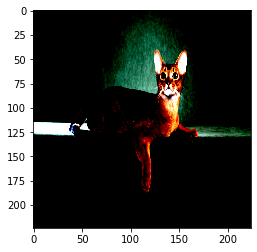

In [11]:
img = cv.cvtColor(cv.imread(str(img_path)),cv.COLOR_BGR2RGB)
img_normalized = (((np.array(img)/255) - imagenet_stats[0]) / imagenet_stats[1]).astype('float32')
plt.imshow(img_normalized);

## Inference Comparisson

### Pytorch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


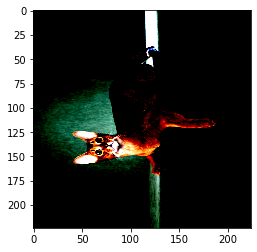

In [13]:
img_tensor = torch.from_numpy(img_normalized.transpose(1,0,2)).cuda().unsqueeze(dim=3).permute(3,2,1,0)
plt.imshow(np.array(img_tensor.squeeze().permute(2,1,0).cpu()));

In [14]:
act_pytorch = learn.model(img_tensor)
if use_bce:
    pred_pytorch = sigmoid(act_pytorch.detach().cpu().numpy())
else:
    pred_pytorch = softmax(act_pytorch.detach().cpu().numpy())
pred_pytorch

array([[9.98955607e-01, 4.95210152e-05, 1.10429346e-06, 4.44218699e-07,
        2.61611876e-05, 8.94291225e-05, 2.20422135e-06, 7.88050966e-06,
        3.68416331e-05, 3.05331778e-04, 2.14479351e-05, 8.92982916e-06,
        4.10581606e-06, 9.98949417e-07, 1.17091840e-04, 6.66043270e-05,
        5.85837770e-05, 4.59970579e-06, 1.51066715e-05, 3.05510275e-06,
        8.05893796e-06, 5.65607843e-06, 1.76310186e-06, 4.87066643e-07,
        3.74765332e-05, 2.47970340e-04, 4.09021226e-07, 3.76869093e-06,
        5.35690742e-06, 1.75788034e-06, 1.56111928e-05, 1.71052583e-04,
        1.12137434e-06, 4.99829330e-05, 5.66292256e-05]], dtype=float32)

In [15]:
%timeit -n 100 learn.model(img_tensor)

18.9 ms ± 773 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Fastai

In [16]:
#outputs= []
#def hook(module, input, output):
#    outputs.append(output)
#learn.model[1][8].register_forward_hook(hook)
pred_fastai = learn.predict(img_path);pred_fastai

((#1) ['Abyssinian'],
 tensor([ True, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False]),
 tensor([9.9905e-01, 9.2538e-04, 1.1016e-06, 1.4480e-06, 2.3369e-05, 4.8705e-05,
         3.9361e-06, 1.0534e-05, 7.6025e-05, 1.4202e-04, 3.7053e-05, 2.9944e-06,
         3.0416e-06, 3.5560e-06, 1.1867e-04, 6.8149e-05, 8.8881e-05, 6.5917e-06,
         2.6275e-05, 6.5779e-07, 1.0130e-05, 6.1924e-06, 2.6426e-06, 4.1486e-07,
         8.0928e-05, 1.3873e-04, 7.9967e-07, 8.9397e-06, 6.0018e-06, 3.2887e-06,
         2.6070e-05, 6.6052e-05, 6.1794e-07, 7.6025e-05, 4.0695e-05]))

### OpenCV

In [17]:
net = cv.dnn_ClassificationModel(onnx_name)

In [18]:
net.setInputSize(224, 224)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CUDA)
act_opencv = net.predict(img_normalized)[0]
if use_bce:
    pred_opencv = sigmoid(act_opencv)
else:
    pred_opencv = softmax(act_opencv)
pred_opencv

array([[9.98955607e-01, 4.95210625e-05, 1.10429346e-06, 4.44219978e-07,
        2.61611131e-05, 8.94297191e-05, 2.20423181e-06, 7.88051784e-06,
        3.68417750e-05, 3.05331778e-04, 2.14479351e-05, 8.92991375e-06,
        4.10583198e-06, 9.98951350e-07, 1.17092175e-04, 6.66045162e-05,
        5.85835551e-05, 4.59972307e-06, 1.51067579e-05, 3.05510275e-06,
        8.05896889e-06, 5.65610526e-06, 1.76310857e-06, 4.87069883e-07,
        3.74767114e-05, 2.47971533e-04, 4.09022419e-07, 3.76870162e-06,
        5.35694335e-06, 1.75788705e-06, 1.56112674e-05, 1.71053573e-04,
        1.12137855e-06, 4.99828857e-05, 5.66293347e-05]], dtype=float32)

In [19]:
(np.linalg.norm(act_opencv - act_pytorch.detach().cpu().numpy()),
np.linalg.norm(pred_opencv - np.array(pred_fastai[2])))

(2.4239092e-05, 0.0009130793)

## Benchmarks

In [12]:
def bench(model,backend,target,img,sz,n_images = 1):
    learn.model.eval();
    dummy_input = torch.randn(n_images, 3, sz[0],sz[1]).cuda()
    torch.onnx.export(learn.model, dummy_input, onnx_name,
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'])
    net = cv.dnn_ClassificationModel(model)
    net.setInputSize(sz)
    net.setPreferableBackend(backend)
    net.setPreferableTarget(target) 
    blob = cv.dnn.blobFromImages([img]*n_images, size = sz)
    net.setInput(blob)
    res = net.forward()
    %timeit -r 1 -n 5 net.forward() # warm up
    %timeit -n 10 net.forward()
    return res

### Single Image

In [29]:
# faster if built with tbb
bench(onnx_name,cv.dnn.DNN_BACKEND_OPENCV,cv.dnn.DNN_TARGET_CPU,img_normalized,(224,224));

34.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
33.8 ms ± 442 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
bench(onnx_name,cv.dnn.DNN_BACKEND_OPENCV,cv.dnn.DNN_TARGET_OPENCL,img_normalized,(224,224));

30.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
24.3 ms ± 648 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [31]:
bench(onnx_name,cv.dnn.DNN_BACKEND_OPENCV,cv.dnn.DNN_TARGET_OPENCL_FP16,img_normalized,(224,224));

23.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
24 ms ± 90.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
bench(onnx_name,cv.dnn.DNN_BACKEND_CUDA,cv.dnn.DNN_TARGET_CUDA,img_normalized,(224,224));

2.92 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
2.93 ms ± 42.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [33]:
bench(onnx_name,cv.dnn.DNN_BACKEND_CUDA,cv.dnn.DNN_TARGET_CUDA_FP16,img_normalized,(224,224));

2.98 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
2.99 ms ± 22.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Multiple Images

In [34]:
bench(onnx_name,cv.dnn.DNN_BACKEND_CUDA,cv.dnn.DNN_TARGET_CUDA,img_normalized,(224,224),1);

3.71 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
3.17 ms ± 255 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [35]:
bench(onnx_name,cv.dnn.DNN_BACKEND_CUDA,cv.dnn.DNN_TARGET_CUDA,img_normalized,(224,224),2);

4.56 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
4.06 ms ± 422 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [36]:
bench(onnx_name,cv.dnn.DNN_BACKEND_CUDA,cv.dnn.DNN_TARGET_CUDA,img_normalized,(224,224),4);

7.66 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
6.3 ms ± 348 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [37]:
bench(onnx_name,cv.dnn.DNN_BACKEND_CUDA,cv.dnn.DNN_TARGET_CUDA,img_normalized,(224,224),8);

9.17 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
9.92 ms ± 430 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
bench(onnx_name,cv.dnn.DNN_BACKEND_CUDA,cv.dnn.DNN_TARGET_CUDA,img_normalized,(224,224),16);

20.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
18 ms ± 519 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
bench(onnx_name,cv.dnn.DNN_BACKEND_CUDA,cv.dnn.DNN_TARGET_CUDA,img_normalized,(224,224),32);

35.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
35.7 ms ± 66.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
